In [1]:
# install azure_blob_storage , dotenv
# !python -m pip install azure-blob-storage 
# !python -m pip dotenv
!python -m pip install azure-storage-blob

In [2]:
!python -m pip install dotenv

  Using cached dotenv-0.0.5.tar.gz (2.4 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [67 lines of output]
      c:\Users\Yathrip\anaconda3\Lib\site-packages\setuptools\__init__.py:94: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
      !!
      
              ********************************************************************************
              Requirements should be satisfied by a PEP 517 installer.
              If you are using pip, you can try `pip install --use-pep517`.
              ********************************************************************************
      
      !!
        dist.fetch_build_eggs(dist.setup_requires)
        error: subprocess-exited-with-error
      
        × python setup.py egg_info did not run successfully.
        │ exit code: 1
        ╰─> [1 lines of output]
            ERROR: Can not execute `setup.py` since setuptools is not available in the build environment.
         

In [3]:
# import necessary libraries
import pandas as pd
from azure.storage.blob import BlobServiceClient
from dotenv import load_dotenv
import os

In [5]:
# Data Extraction
df = pd.read_csv(r'D:\10alytics Data Engineering\week 11\Zipco_Food_Case_Study\zipco_transaction.csv')
df.head()

,Date,ProductName,Quantity,UnitPrice,StoreLocation,PaymentType,PromotionApplied,Weather,Temperature,StaffPerformanceRating,...,DeliveryTime_min,OrderType,CustomerName,CustomerAddress,Customer_PhoneNumber,CustomerEmail,Staff_Name,Staff_Email,DayOfWeek,TotalSales
0,2023-01-01 00:00:00,Vanilla Cake,2,12.532304,South,Cash,True,Rainy,20.654914,Poor,...,30,In Store,William Adams,"9851 David Green\r\nTonyaburgh, VA 02853",(916)427-7276x861,lisa00@example.net,John Bridges,pdavidson@example.com,Sunday,25.064608
1,2023-01-01 01:00:00,Red Velvet Cake,1,7.083070,South,Cash,False,Rainy,23.549497,Average,...,33,In Store,Anthony Wiggins,"24682 Holly Stravenue\r\nMooreville, NH 13901",769.318.4373,michellefernandez@example.com,Sarah Bentley,ajohnson@example.net,Sunday,7.083070
2,2023-01-01 02:00:00,Chocolate Cake,5,6.736064,North,Cash,True,Rainy,NaN,Excellent,...,43,Phone Order,Ashley Duke,10184 Washington Trace Apt. 679\r\nEast Brandi...,702.520.3286,cooperwilliam@example.com,Connie Cervantes,michele29@example.net,Sunday,33.680321
3,2023-01-01 03:00:00,Carrot Cake,2,7.314823,North,Cash,False,Cloudy,20.137483,Poor,...,32,Online Order,Brandon Taylor,"87194 Jeff Rue\r\nMitchellbury, CA 50463",622-527-9530,fsilva@example.net,Jessica Stewart,xwilson@example.org,Sunday,14.629647
4,2023-01-01 04:00:00,Pizza Pepperoni,1,7.577727,East,Credit Card,True,Cloudy,23.020987,Good,...,58,In Store,Brittany Watkins,"850 Julia Groves\r\nHartview, WI 95954",759-517-8359,petersjoseph@example.net,Cheryl Carpenter,christine96@example.org,Sunday,7.577727


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Date                    1005 non-null   object 
 1   ProductName             1005 non-null   object 
 2   Quantity                1005 non-null   int64  
 3   UnitPrice               1005 non-null   float64
 4   StoreLocation           1005 non-null   object 
 5   PaymentType             1005 non-null   object 
 6   PromotionApplied        1005 non-null   bool   
 7   Weather                 1005 non-null   object 
 8   Temperature             904 non-null    float64
 9   StaffPerformanceRating  1005 non-null   object 
 10  CustomerFeedback        905 non-null    object 
 11  DeliveryTime_min        1005 non-null   int64  
 12  OrderType               1005 non-null   object 
 13  CustomerName            1005 non-null   object 
 14  CustomerAddress         1005 non-null   

Data Cleaning

In [7]:
#drop duplicates
df = df.drop_duplicates()

In [12]:
for i in df.columns:
    if df[i].dtypes == 'object':
        df[i] = df[i].fillna('unknown')  #columns with string values
    else:
        df[i] = df[i].fillna(df[i].mean())    #columns with numeric values

In [13]:
df.isnull().sum()

Date                      0
ProductName               0
Quantity                  0
UnitPrice                 0
StoreLocation             0
PaymentType               0
PromotionApplied          0
Weather                   0
Temperature               0
StaffPerformanceRating    0
CustomerFeedback          0
DeliveryTime_min          0
OrderType                 0
CustomerName              0
CustomerAddress           0
Customer_PhoneNumber      0
CustomerEmail             0
Staff_Name                0
Staff_Email               0
DayOfWeek                 0
TotalSales                0
dtype: int64

Data is clean

Data Modeling Schema

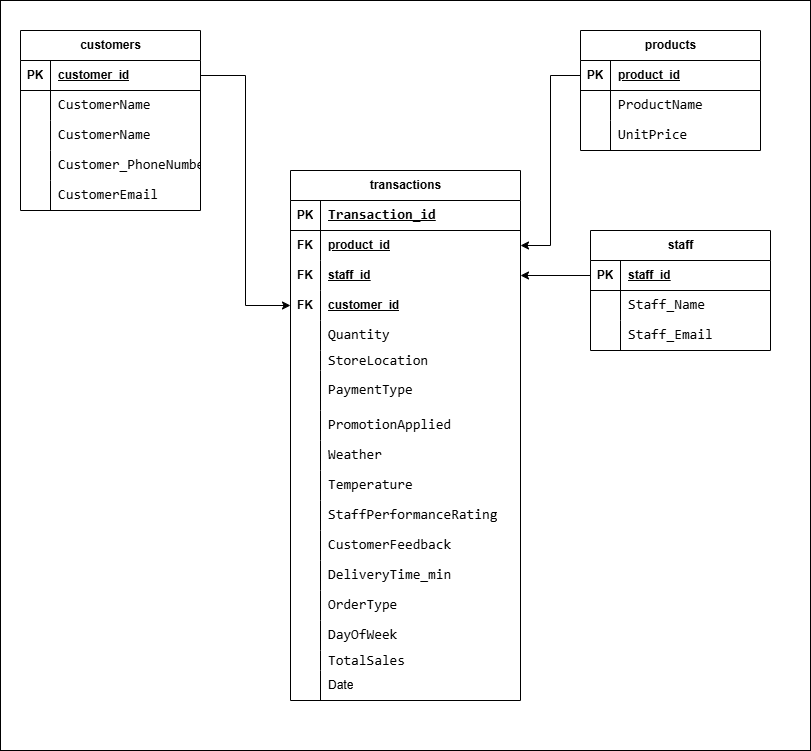

In [16]:
#create table products
products = df[['ProductName','UnitPrice']].copy().drop_duplicates().reset_index()
products['product_id'] = range(1,len(products)+1)
products = products[['product_id','ProductName','UnitPrice']]
products.head()

,product_id,ProductName,UnitPrice
0,1,Vanilla Cake,12.532304
1,2,Red Velvet Cake,7.083070
2,3,Chocolate Cake,6.736064
3,4,Carrot Cake,7.314823
4,5,Pizza Pepperoni,7.577727


In [17]:
#create table customers
customers = df[['CustomerName', 'CustomerAddress', 'Customer_PhoneNumber','CustomerEmail']].copy().drop_duplicates().reset_index()
customers['customer_id'] = range(1,len(customers)+1)
customers = customers[['customer_id','CustomerName', 'CustomerAddress', 'Customer_PhoneNumber','CustomerEmail']]
customers.head()

,customer_id,CustomerName,CustomerAddress,Customer_PhoneNumber,CustomerEmail
0,1,William Adams,"9851 David Green\r\nTonyaburgh, VA 02853",(916)427-7276x861,lisa00@example.net
1,2,Anthony Wiggins,"24682 Holly Stravenue\r\nMooreville, NH 13901",769.318.4373,michellefernandez@example.com
2,3,Ashley Duke,10184 Washington Trace Apt. 679\r\nEast Brandi...,702.520.3286,cooperwilliam@example.com
3,4,Brandon Taylor,"87194 Jeff Rue\r\nMitchellbury, CA 50463",622-527-9530,fsilva@example.net
4,5,Brittany Watkins,"850 Julia Groves\r\nHartview, WI 95954",759-517-8359,petersjoseph@example.net


In [18]:
#create table staff
staff = df[['Staff_Name', 'Staff_Email']].copy().drop_duplicates().reset_index()
staff['staff_id'] = range(1,len(staff)+1)
staff = staff[['staff_id','Staff_Name', 'Staff_Email']]
staff.head()

,staff_id,Staff_Name,Staff_Email
0,1,John Bridges,pdavidson@example.com
1,2,Sarah Bentley,ajohnson@example.net
2,3,Connie Cervantes,michele29@example.net
3,4,Jessica Stewart,xwilson@example.org
4,5,Cheryl Carpenter,christine96@example.org


In [23]:
#create table transactions
transactions = df.merge(products,on=['ProductName','UnitPrice'],how='left')\
                 .merge(customers,on=['CustomerName', 'CustomerAddress', 'Customer_PhoneNumber','CustomerEmail'],how='left')\
                 .merge(staff,on=['Staff_Name', 'Staff_Email'],how='left')
transactions['transaction_id'] = range(1,len(transactions)+1)
transactions = transactions.reset_index()\
            [['transaction_id','product_id','customer_id','staff_id','Quantity',
              'StoreLocation','PaymentType', 'PromotionApplied', 'Weather', 'Temperature',
                'StaffPerformanceRating', 'CustomerFeedback', 'DeliveryTime_min','OrderType',
                'DayOfWeek','TotalSales','Date']]
transactions

,transaction_id,product_id,customer_id,staff_id,Quantity,StoreLocation,PaymentType,PromotionApplied,Weather,Temperature,StaffPerformanceRating,CustomerFeedback,DeliveryTime_min,OrderType,DayOfWeek,TotalSales,Date
0,1,1,1,1,2,South,Cash,True,Rainy,20.654914,Poor,Neutral,30,In Store,Sunday,25.064608,2023-01-01 00:00:00
1,2,2,2,2,1,South,Cash,False,Rainy,23.549497,Average,Positive,33,In Store,Sunday,7.083070,2023-01-01 01:00:00
2,3,3,3,3,5,North,Cash,True,Rainy,27.154342,Excellent,unknown,43,Phone Order,Sunday,33.680321,2023-01-01 02:00:00
3,4,4,4,4,2,North,Cash,False,Cloudy,20.137483,Poor,Positive,32,Online Order,Sunday,14.629647,2023-01-01 03:00:00
4,5,5,5,5,1,East,Credit Card,True,Cloudy,23.020987,Good,Neutral,58,In Store,Sunday,7.577727,2023-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,996,996,996,2,North,Credit Card,True,Rainy,28.787946,Poor,Negative,29,In Store,Saturday,22.449136,2023-02-11 11:00:00
996,997,997,997,997,3,East,Credit Card,False,Cloudy,34.641175,Good,Positive,32,In Store,Saturday,47.074995,2023-02-11 12:00:00
997,998,998,998,998,3,West,Cash,True,Sunny,27.984565,Average,unknown,43,Phone Order,Saturday,32.379540,2023-02-11 13:00:00
998,999,999,999,999,5,East,Online,True,Rainy,33.579827,Poor,Positive,52,Online Order,Saturday,69.137870,2023-02-11 14:00:00


In [24]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   transaction_id          1000 non-null   int64  
 1   product_id              1000 non-null   int64  
 2   customer_id             1000 non-null   int64  
 3   staff_id                1000 non-null   int64  
 4   Quantity                1000 non-null   int64  
 5   StoreLocation           1000 non-null   object 
 6   PaymentType             1000 non-null   object 
 7   PromotionApplied        1000 non-null   bool   
 8   Weather                 1000 non-null   object 
 9   Temperature             1000 non-null   float64
 10  StaffPerformanceRating  1000 non-null   object 
 11  CustomerFeedback        1000 non-null   object 
 12  DeliveryTime_min        1000 non-null   int64  
 13  OrderType               1000 non-null   object 
 14  DayOfWeek               1000 non-null   o

In [26]:
#convert date column to date type
transactions['Date'] = pd.to_datetime(transactions['Date'])
transactions['Date'].dtypes

dtype('<M8[ns]')

In [29]:
#save data
products.to_csv(r'D:\10alytics Data Engineering\week 11\Zipco_Food_Case_Study\clean data\products.csv',index=False)
customers.to_csv(r'D:\10alytics Data Engineering\week 11\Zipco_Food_Case_Study\clean data\customers.csv',index=False)
staff.to_csv(r'D:\10alytics Data Engineering\week 11\Zipco_Food_Case_Study\clean data\staff.csv',index=False)
transactions.to_csv(r'D:\10alytics Data Engineering\week 11\Zipco_Food_Case_Study\clean data\transactions.csv',index=False)
print('Data saved successfully')

Data saved successfully


Data Loading

In [30]:
# Load the environment .env variables from the .env files
load_dotenv()

connect_str = os.getenv('AZURE_CONNECTION_STRING_VALUE')
container_name = os.getenv('CONTAINER_NAME')

In [32]:
# create BlobServiceClient object

blob_service_client = BlobServiceClient.from_connection_string(connect_str)
container_client = blob_service_client.get_container_client(container_name)

# Load data to Azure Blob Storage
files = [
    (products , 'cleaneddata/products.csv'),
    (customers , 'cleaneddata/customers.csv'),
    (staff , 'cleaneddata/staff.csv'),
    (transactions , 'cleaneddata/transactions.csv')
]

for file , blob_name in files :
    blob_client = container_client.get_blob_client(blob_name)
    output = file.to_csv(index=False)
    blob_client.upload_blob(output , overwrite = True)
    print(f'{blob_name} loaded into Azure Blob Storage Successfully')

cleaneddata/products.csv loaded into Azure Blob Storage Successfully
cleaneddata/customers.csv loaded into Azure Blob Storage Successfully
cleaneddata/staff.csv loaded into Azure Blob Storage Successfully
cleaneddata/transactions.csv loaded into Azure Blob Storage Successfully
